# Autoreload and logging config

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# configure logging
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('Assignment2RRBSDataSource').setLevel(logging.DEBUG)
logging.getLogger('GlmNetEpigeneticClockTrainer').setLevel(logging.DEBUG)
logging.getLogger('download_file').setLevel(logging.DEBUG)

# Download data files

In [2]:
%%time
import os
from epigenetic_clock_assignment import download_file

data_dir = 'data/assignment2'
meta_csv_filepath = os.path.join(data_dir, 'MetaPolished.csv')
features_csv_filepath = os.path.join(data_dir, 'FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv')
features_zip_filepath = os.path.join(data_dir, 'FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv.zip')

# download meta file
download_file(url='https://kerepesi.web.elte.hu/bioinf_ora/MetaPolished.csv',
              out_filepath=meta_csv_filepath)

# download features file if does not exists
download_file(url='https://kerepesi.web.elte.hu/bioinf_ora/FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv.zip',
              out_filepath=features_csv_filepath, 
              intermediate_archive_filepath=features_zip_filepath,
              archive_format='zip')


DEBUG:download_file:file data/assignment2/MetaPolished.csv already exists; do not download again
DEBUG:download_file:file data/assignment2/FTGenForGenomicCov_MergeStrands.py-cov5.csv-dropna.py-1.0.csv-Format.py.csv already exists; do not download again


CPU times: user 1.79 s, sys: 3.99 s, total: 5.78 s
Wall time: 854 ms


# Load data

In [3]:
%%time

import os
from epigenetic_clock_assignment import Assignment2RRBSDataSource

data_source = Assignment2RRBSDataSource(
    meta_csv_filepath=meta_csv_filepath,
    features_csv_filepath=features_csv_filepath,
    features_pickle_cache_filepath=os.path.join(data_dir, 'features_cache.pickle'))

X, y, meta_df = data_source.load()

print(meta_df)

DEBUG:Assignment2RRBSDataSource:load
DEBUG:Assignment2RRBSDataSource:loading features from cache file "data/assignment2/features_cache.pickle"...
DEBUG:Assignment2RRBSDataSource:loaded; shape=(182, 5201794)
DEBUG:Assignment2RRBSDataSource:joining based on ID
DEBUG:Assignment2RRBSDataSource:joined; shape=(182, 5201797)
DEBUG:Assignment2RRBSDataSource:creating y
DEBUG:Assignment2RRBSDataSource:creating X
DEBUG:Assignment2RRBSDataSource:loaded


            Gender Condition
acc                         
SRR9190430    Male   Healthy
SRR9190431    Male   Healthy
SRR9190432    Male   Healthy
SRR9190433  Female   Healthy
SRR9190434    Male   Healthy
...            ...       ...
SRR9190788    Male   Healthy
SRR9190789    Male   Healthy
SRR9190790    Male   Healthy
SRR9190791  Female   Healthy
SRR9190792  Female   Healthy

[182 rows x 2 columns]
CPU times: user 2.7 s, sys: 1.83 s, total: 4.53 s
Wall time: 5.17 s


# Hyperparameter optimization (ElasticNet $\lambda, \alpha$)

In [4]:
%%time
from epigenetic_clock_assignment import GlmNetEpigeneticClockTrainer

clock_trainer = GlmNetEpigeneticClockTrainer(
    n_parallel_jobs=1,
    n_cv_fold=3,
    # the weight of standard error used to determine lambda_best, 0 means use lambda_max (see glmnet.ElasticNet)
    std_error_weight_for_lambda_best=0.5,
    seed=42
)

X_train, X_test, y_train, y_test, meta_train, meta_test = clock_trainer.train_test_split(X, y, meta_df,
                                                                  test_size=0.2)

hyperparameter_result, hyperparameter_stats, best_model = clock_trainer.hyperparameter_optimization(
    X_train=X_train, 
    y_train=y_train, 
    alpha_count= 2 + 1)


DEBUG:GlmNetEpigeneticClockTrainer:starting hyperparameter optimization with alpha range [0.  0.5 1. ]
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.0...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.5...
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 1.0...


CPU times: user 3min 57s, sys: 1min 19s, total: 5min 16s
Wall time: 4min 34s


# Plot hyperparameter optimization result

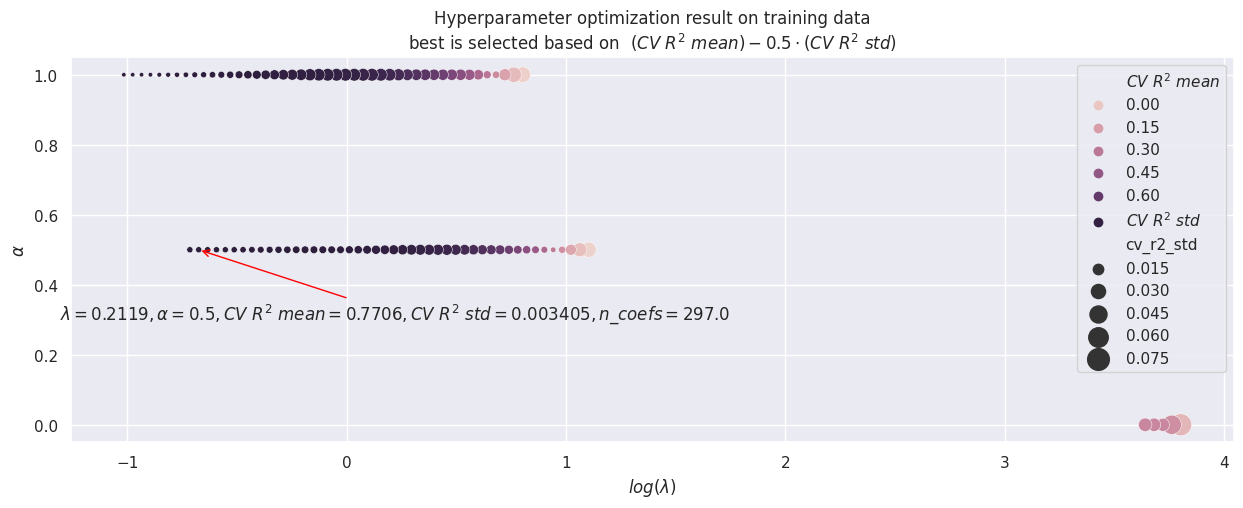

In [5]:
clock_trainer.plot_hyperparameter_optimization_result(
    hyperparameter_result=hyperparameter_result, 
    hyperparameter_stats=hyperparameter_stats)

# Predict on test data using the best model

In [6]:
best_lambda = hyperparameter_result.lambd
best_alpha = hyperparameter_result.alpha

# sanity check
assert best_model.alpha == best_alpha
assert best_model.lambda_best_ == best_lambda

# predict
y_test_pred = best_model.predict(X = X_test, lamb=best_lambda)


# Plot linear regression result on test data

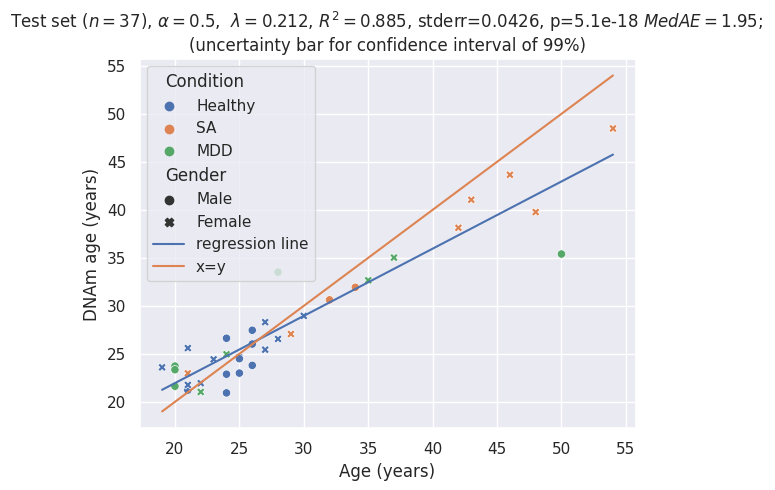

Statistics(r2=0.8850712875132539, slope=0.7000855055693106, intercept=7.95217386033589, p_value=5.1203883258762195e-18, standard_error=0.04264245587236598, medae=1.9495835386266762, delta_age=array([ -3.06696546,  -3.87008208,  -2.34628938,   1.42932615,
         1.97583897,  -1.04340167,  -1.12031954,   5.51302135,
        -0.96893238,  -0.36839751,  -1.37531177,   3.72562469,
         0.96246371,  -1.97409777,   2.62493483,   1.45800981,
        -1.93429997,  -8.23096703,  -2.19934423,   1.30202994,
         1.62520019,   0.22315956,  -0.50098297,   4.59518413,
        -5.52284255,   0.76560272,  -1.56462461,  -2.0059753 ,
       -14.60061972,   0.02147608,  -2.33736245,  -2.06788129,
        -1.94958354,   4.60125997,   3.34844287,  -0.05519758,
        -1.44625788]), age_acceleration=array([-3.82119145e+00,  7.74152824e-01,  3.49760350e+00,  3.75185659e-01,
        3.21869492e-01,  1.85930404e-03, -1.87454553e+00,  5.95845333e+00,
       -2.32298737e+00, -8.22709013e-01,  2.6977819

In [7]:
test_stats = clock_trainer.calculate_statistics(y_true=y_test, y_pred=y_test_pred)
clock_trainer.plot_linear_regression_result(
    y_true=y_test, 
    y_pred=y_test_pred, 
    stats=test_stats, 
    alpha=best_alpha, 
    lamb=best_lambda,
    title_prefix='Test set',
    hue=meta_test['Condition'],
    style=meta_test['Gender'])

print(test_stats)


In [8]:
# predict
y_pred = best_model.predict(X = X, lamb=best_lambda)


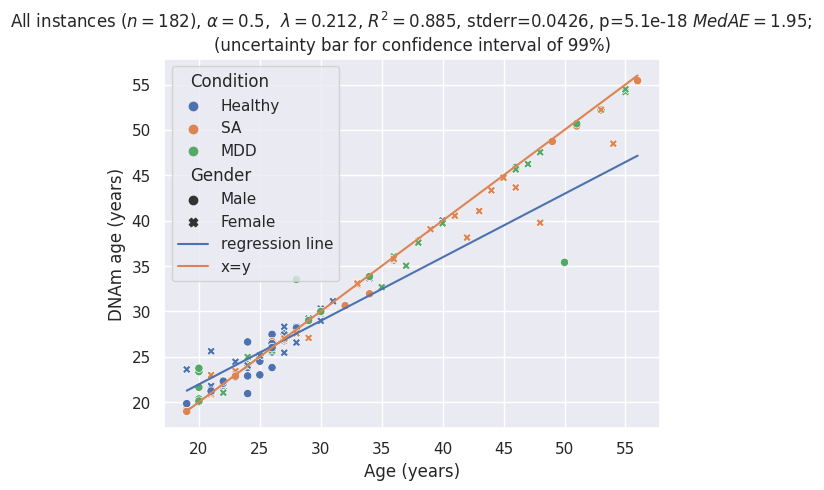

In [9]:
stats = clock_trainer.calculate_statistics(y_true=y, y_pred=y_pred)
clock_trainer.plot_linear_regression_result(
    y_true=y, 
    y_pred=y_pred, 
    stats=test_stats, 
    alpha=best_alpha, 
    lamb=best_lambda,
    title_prefix='All instances',
    hue=meta_df['Condition'],
    style=meta_df['Gender'])



            Gender Condition  age_acceleration  delta_age   age   pred_age
acc                                                                       
SRR9190430    Male   Healthy         -0.077194   0.166351  24.0  24.166351
SRR9190431    Male   Healthy          0.154585  -0.103906  30.0  29.896094
SRR9190432    Male   Healthy          0.201762  -0.056729  30.0  29.943271
SRR9190433  Female   Healthy         -0.098266   0.228952  23.0  23.228952
SRR9190434    Male   Healthy         -0.229436  -0.236909  27.0  26.763091
...            ...       ...               ...        ...   ...        ...
SRR9190788    Male   Healthy         -0.283159   0.211404  21.0  21.211404
SRR9190789    Male   Healthy         -0.113755   0.297136  22.0  22.297136
SRR9190790    Male   Healthy         -0.076015   0.000185  26.0  26.000185
SRR9190791  Female   Healthy         -0.043833   0.116039  25.0  25.116039
SRR9190792  Female   Healthy         -0.213109   0.030436  24.0  24.030436

[182 rows x 6 columns]
 

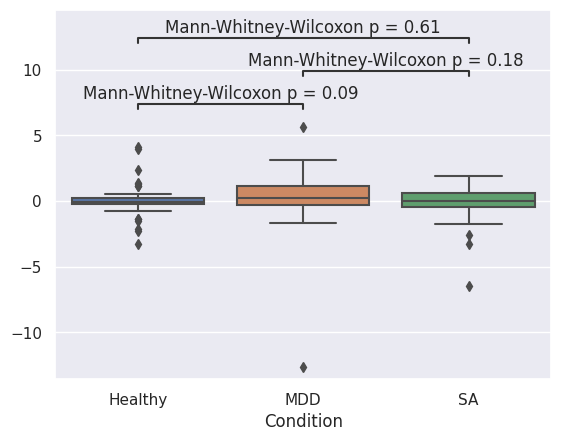

In [34]:
import seaborn as sns
import scipy.stats as scipystats
import pandas as pd
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

order = ['Healthy', 'MDD', 'SA']
fig, ax = plt.subplots()

plotting_parameters = {
    'x': meta_df['Condition'],
    'y': stats.age_acceleration,
    'order': order
}

sns.boxplot(ax=ax, **plotting_parameters)

meta_with_stats_df = meta_df.copy()
meta_with_stats_df['age_acceleration'] = stats.age_acceleration
meta_with_stats_df['delta_age'] = stats.delta_age
meta_with_stats_df['age'] = y
meta_with_stats_df['pred_age'] = y_pred
print(meta_with_stats_df)

print(meta_df.groupby('Condition').count())

def check_normality(x: pd.Series):
    res = scipystats.shapiro(x) 
    return res.pvalue

print(meta_with_stats_df['age_acceleration'].agg(is_normal_p_value=lambda x: check_normality(x)))

print(meta_with_stats_df.groupby('Condition')['age_acceleration'].agg(is_normal_p_value=lambda x: check_normality(x)))
# age acceleration is not normally distributed

print('age is normal', meta_with_stats_df.groupby('Condition')['age'].agg(is_normal_p_value=lambda x: check_normality(x)))
print('age is normal in whole dataset', meta_with_stats_df['age'].agg(is_normal_p_value=lambda x: check_normality(x)))


# non normally distributed, we will use Mann-Whitney-Wilcoxon

condition_groupby = meta_with_stats_df.groupby('Condition')
healthy_group = condition_groupby.get_group('Healthy')
mdd_group = condition_groupby.get_group('MDD')
sa_group = condition_groupby.get_group('SA')

healthy_vs_mdd = scipystats.mannwhitneyu(healthy_group['age_acceleration'], mdd_group['age_acceleration'])
healthy_vs_sa = scipystats.mannwhitneyu(healthy_group['age_acceleration'], sa_group['age_acceleration'])
mdd_vs_sa = scipystats.mannwhitneyu(mdd_group['age_acceleration'], sa_group['age_acceleration'])
print('healthy_vs_mdd', healthy_vs_mdd)
print('healthy_vs_sa', healthy_vs_sa)
print('mdd_vs_sa', mdd_vs_sa)
# TODO: https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00

pairs = [('Healthy', 'MDD'), ('Healthy', 'SA'), ('MDD', 'SA')]

annotator = Annotator(ax, pairs, **plotting_parameters)
#annotator.set_custom_annotations(['1', '2', '3'])
annotator.configure(text_format="simple", test_short_name='Mann-Whitney-Wilcoxon')
annotator.set_pvalues([healthy_vs_mdd.pvalue, healthy_vs_sa.pvalue, mdd_vs_sa.pvalue])
annotator.annotate()
ax.set_ylabel(')
plt.show()

In [ ]:
stats = clock_trainer.calculate_statistics(y_true=y, y_pred=y_all_pred)

clock_trainer.plot_linear_regression_result(
    y_true=y, 
    y_pred=y_all_pred, 
    stats=stats, 
    alpha=best_alpha, 
    lamb=best_lambda,
    hue=meta_df['Condition'],
    style=meta_df['Gender'])

#print(stats)
